In [1]:
from transformers import MarianTokenizer, MarianMTModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import pandas as pd
from transformers import DataCollatorForSeq2Seq
import torch
import numpy as np
from torch.utils.data import Dataset
from nltk.translate.bleu_score import corpus_bleu
from transformers import pipeline

/home/slim/PycharmProjects/VisTranslator/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-01 15:23:59.376476: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 15:23:59.386463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748780639.398615   25116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748780639.402263   25116 cu

In [2]:
# Завантаження моделі та токенізатора
model_name = "Helsinki-NLP/opus-mt-en-uk"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/home/slim/PycharmProjects/VisTranslator/.venv/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [3]:
# Завантаження датасету з CSV (за допомогою роздільника табуляції)
df = pd.read_csv("unique_expanded_idioms.csv", delimiter=';')

In [4]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df)

,Example Sentence,Translation Sentence (Ukrainian)
0,This challenge is not a piece of cake.,Це завдання не легке.
1,The math exam was a piece of cake for her.,Математичний іспит був для неї дуже легким.
2,Learning to ride a bike was a piece of cake for him.,Навчання їзди на велосипеді було для нього дуже легким.
3,The presentation was a piece of cake after all the preparation.,Презентація була дуже легкою після всієї підготовки.
4,Fixing the computer was a piece of cake for the technician.,Ремонт комп'ютера був дуже легким для техніка.
...,...,...
762,He was so engrossed in his book that he missed the boat announcement.,"Він так захопився книгою, що пропустив оголошення про відправлення човна."
763,"If we don't leave now, we'll have missed the boat for the scenic tour.","Якщо ми не виїдемо зараз, ми спізнимося на човен для оглядової екскурсії."
764,The children were disappointed because they missed the boat ride.,"Діти були розчаровані, бо спізнилися на прогулянку на човні."
765,"He double-checked his ticket, hoping he hadn't missed the boat.","Він двічі перевірив свій квиток, сподіваючись, що не спізнився на човен."


In [5]:
# Створення власного PyTorch Dataset
class TranslationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_lang, target_lang, prefix,
        max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.prefix = prefix
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source_text = self.prefix + self.data.iloc[idx][self.source_lang]
        target_text = self.data.iloc[idx][self.target_lang]
        # Токенізація
        model_inputs = self.tokenizer(source_text, text_target=target_text,
        max_length=self.max_length, truncation=True)
        return model_inputs

/tmp/ipykernel_25116/3408791151.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
15,1.701700
30,1.115800
45,0.771700
60,0.562800
75,0.483400
90,0.401800
105,0.361900
120,0.327900
135,0.281500


/home/slim/PycharmProjects/VisTranslator/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61586]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


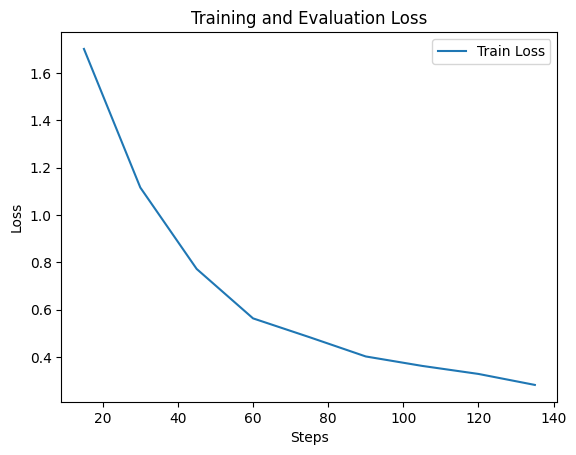

In [6]:
from transformers import TrainingArguments
import matplotlib.pyplot as plt

source_lang = "Example Sentence"
target_lang = "Translation Sentence (Ukrainian)"
prefix = "translate English to Ukrainian: "
dataset = TranslationDataset(df, tokenizer, source_lang, target_lang, prefix)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
train_data = dataset

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=15,
)
training_args.generation_config = None
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()
# Після тренування:
history = trainer.state.log_history

# Візуалізація loss
train_loss = [x["loss"] for x in history if "loss" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
steps = [x["step"] for x in history if "loss" in x]

plt.plot(steps, train_loss, label="Train Loss")
if eval_loss:
    eval_steps = [x["step"] for x in history if "eval_loss" in x]
    plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")
plt.show()

In [7]:
#torch.save(model.state_dict(), 'fine_tuned_weights.pth')

In [11]:
### Розультат до файнтюнінгу моделі

model_before_ft = MarianMTModel.from_pretrained(model_name)

# Тестові приклади
test_sentences = [
"This challenge is not a piece of cake.",
"He told a funny story to break the ice at the conference.",
"You really hit the nail on the head with that analysis.",
"I feel under the weather, so I’ll stay home today.",
"He accidentally spilled the beans about the secret project.",
"We go hiking once in a blue moon.",
"She had to bite the bullet and apologize.",
"Don't let the cat out of the bag about the surprise gift.",
"I was burning the midnight oil to meet the deadline.",
"His remarks only added fuel to the fire."
"I’m nervous about the play tonight, but I’ll just break a leg!",
"You need to make the decision now, the ball is in your court.",
"If you cut corners while cooking, the taste might suffer.",
"I thought you were pulling my leg when you said you met a celebrity.",
"I have to hit the books tonight to prepare for the final exams.",
"This designer bag costs an arm and a leg!",
"Speak of the devil, we were just talking about you!",
"By taking this route, we can visit both museums and kill two birds with one stone.",
"His rude comment was the last straw, and she decided to quit.",
"Be careful not to burn the bridges with your former employer.",
"Losing that job turned out to be a blessing in disguise because he found a better one.",
"There’s no point in crying over spilled milk - just learn from your mistake.",
"Working remotely gives me the best of both worlds - more flexibility and productivity.",
"After months of struggling, he decided to throw in the towel and switch careers.",
"I’m exhausted after a long day, time to hit the sack.",
"He keeps making promises, but actions speak louder than words.",
"We’ve made great progress, let’s call it a day.",

"The new tax policy is a hot potato among politicians.",
"Our new assistant is really on the ball - she learns fast and works efficiently.",
"He wanted to invest in Bitcoin early, but he missed the boat.",
"Fixing a small crack in the wall now will save us from major repairs later - a stitch in time saves nine."
]
# Переклад за допомогою моделі
translator = pipeline("translation", model=model_before_ft, tokenizer=tokenizer)
translated_sentences = [translator(sentence)[0]['translation_text'] for sentence
in test_sentences]
df_results = pd.DataFrame({
"Original Sentence": test_sentences,
"Translated Sentence": translated_sentences
})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df_results)

Device set to use cuda:0


,Original Sentence,Translated Sentence
0,This challenge is not a piece of cake.,Ця проблема не є шматочком торта.
1,He told a funny story to break the ice at the conference.,"Він розповів смішну історію, щоб розбити лід на конференції."
2,You really hit the nail on the head with that analysis.,Ви дійсно вдарили цвяхом по голові з цим аналізом.
3,"I feel under the weather, so I’ll stay home today.","Я чувствую, что под погодой, так что я останусь дома сегодня."
4,He accidentally spilled the beans about the secret project.,Він випадково пролив боби про секретний проект.
5,We go hiking once in a blue moon.,Ми йдемо в похід один раз на синьому місяці.
6,She had to bite the bullet and apologize.,Она должна была укусить пулю и извиниться.
7,Don't let the cat out of the bag about the surprise gift.,Не випускайте кота з сумки про несподіваний подарунок.
8,I was burning the midnight oil to meet the deadline.,"Я спалював північну олію, щоб зустріти кінцевий термін."
9,"His remarks only added fuel to the fire.I’m nervous about the play tonight, but I’ll just break a leg!","Его чаи только добавили пального пожару. Я сегодня волнуюсь за пьесу, но я просто сломаю ногу!"


In [12]:
# Тестові приклади
test_sentences = [
"This challenge is not a piece of cake.",
"He told a funny story to break the ice at the conference.",
"You really hit the nail on the head with that analysis.",
"I feel under the weather, so I’ll stay home today.",
"He accidentally spilled the beans about the secret project.",
"We go hiking once in a blue moon.",
"She had to bite the bullet and apologize.",
"Don't let the cat out of the bag about the surprise gift.",
"I was burning the midnight oil to meet the deadline.",
"His remarks only added fuel to the fire."
"I’m nervous about the play tonight, but I’ll just break a leg!",
"You need to make the decision now, the ball is in your court.",
"If you cut corners while cooking, the taste might suffer.",
"I thought you were pulling my leg when you said you met a celebrity.",
"I have to hit the books tonight to prepare for the final exams.",
"This designer bag costs an arm and a leg!",
"Speak of the devil, we were just talking about you!",
"By taking this route, we can visit both museums and kill two birds with one stone.",
"His rude comment was the last straw, and she decided to quit.",
"Be careful not to burn the bridges with your former employer.",
"Losing that job turned out to be a blessing in disguise because he found a better one.",
"There’s no point in crying over spilled milk - just learn from your mistake.",
"Working remotely gives me the best of both worlds - more flexibility and productivity.",
"After months of struggling, he decided to throw in the towel and switch careers.",
"I’m exhausted after a long day, time to hit the sack.",
"He keeps making promises, but actions speak louder than words.",
"We’ve made great progress, let’s call it a day.",
"The new tax policy is a hot potato among politicians.",
"Our new assistant is really on the ball - she learns fast and works efficiently.",
"He wanted to invest in Bitcoin early, but he missed the boat.",
"Fixing a small crack in the wall now will save us from major repairs later - a stitch in time saves nine."

]
# Переклад за допомогою моделі
translator = pipeline("translation", model=model, tokenizer=tokenizer)
translated_sentences = [translator(sentence)[0]['translation_text'] for sentence
in test_sentences]
df_results = pd.DataFrame({
"Original Sentence": test_sentences,
"Translated Sentence": translated_sentences
})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df_results)

Device set to use cuda:0


,Original Sentence,Translated Sentence
0,This challenge is not a piece of cake.,Ця проблема не є дуже легкою.
1,He told a funny story to break the ice at the conference.,"Він розповів смішну історію, щоб розрядити атмосферу на конференції."
2,You really hit the nail on the head with that analysis.,Ти справді влучив у ціль з цим аналізом.
3,"I feel under the weather, so I’ll stay home today.","Я почуваюся зле, тому я залишусь сьогодні вдома."
4,He accidentally spilled the beans about the secret project.,Він випадково проговорився про секретний проект.
5,We go hiking once in a blue moon.,Ми ходимо в похід раз на сто років.
6,She had to bite the bullet and apologize.,Їй довелося зібратись із силами і вибачитися.
7,Don't let the cat out of the bag about the surprise gift.,Не проговорюйся про подарунок-сюрприз.
8,I was burning the midnight oil to meet the deadline.,"Я засиджувався допізна, щоб встигнути до дедлайну."
9,"His remarks only added fuel to the fire.I’m nervous about the play tonight, but I’ll just break a leg!","Його зауваження лише підкинули палива вогонь. Я хвилююсь за виставу сьогодні ввечері, але я просто зламаю ногу!"


In [10]:
# Тестові приклади
test_sentences = [
"Hello.",
"Just a quick email to say that sounds like a great idea.",
"Saturday is better for me because I'm meeting my parents on Sunday.",
"So if that's still good for you, why don't you come here?",
"Then you can see the new flat and all the work we've done on the kitchensince we moved in.",
"We can eat at home and then go for a walk in the afternoon.",
"It's going to be so good to catch up finally.",
"I want to hear all about your new job!",
"Our address is 52 Charles Road, but it's a bit difficult to find becausethe house numbers are really strange here.",
"If you turn left at the post office and keep going past the big white house"
"on Charles Road, there's a small side street behind it with the houses 50–56 in.",
"Don't ask me why the side street doesn't have a different name!",
"Let me know if there's anything you don't like to eat.",
"Really looking forward to seeing you!",
"See you soon!"
]
translator = pipeline("translation", model=model, tokenizer=tokenizer)
translated_sentences = [translator(sentence)[0]['translation_text'] for sentence
in test_sentences]
df_results = pd.DataFrame({
"Original Sentence": test_sentences,
"Translated Sentence": translated_sentences
})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df_results)

Device set to use cuda:0


,Original Sentence,Translated Sentence
0,Hello.,Алло.
1,Just a quick email to say that sounds like a great idea.,"Це звучить, як чудова ідея."
2,Saturday is better for me because I'm meeting my parents on Sunday.,"Субота краща для мене, бо я зустрічаюся з батьками в неділю."
3,"So if that's still good for you, why don't you come here?","Якщо це ще добре, чому б тобі не прийти сюди?"
4,Then you can see the new flat and all the work we've done on the kitchensince we moved in.,"Потім ви можете побачити нову квартиру та всю роботу, яку ми зробили на кухні, перш ніж переїхати."
5,We can eat at home and then go for a walk in the afternoon.,"Ми можемо поїсти вдома, а потім піти на прогулянку по обіді."
6,It's going to be so good to catch up finally.,"Це буде так добре, щоб нарешті наздогнати."
7,I want to hear all about your new job!,Я хочу почути все про твою нову роботу!
8,"Our address is 52 Charles Road, but it's a bit difficult to find becausethe house numbers are really strange here.","Наша адреса - 52, але знайти її досить складно, бо номери будинку дуже дивні."
9,"If you turn left at the post office and keep going past the big white houseon Charles Road, there's a small side street behind it with the houses 50–56 in.","Якщо ти повернеш ліворуч в пошті і продовжиш просуватися повз великий білий будиночок на вулиці Чарльз Роуд, за ним є маленька бічна вулиця з домами 50 з нею."
